# Microarray Data Analysis

**Table of Contents**  
- [Introduction](#intro)
- [GEO Data Types](#data-types)
- [Download and Parse GSE file](#dl-parse)
- [Translate Probesets to Gene Symbols](#probe-to-gene)
- [Data Analysis: Determine Sample Groups](#da-sample-groups)
- [Data Analysis: Find Differentially Expressed Genes](#da-degs)
  - [Plot Expression Levels of Top 5 Genes](#da-top-5-expr)
- [Data Analysis: Hierarchical Clustering](#da-hierarchical)
- [Data Analysis: Flat Clustering](#da-flat)
- [Data Analysis: k-Means Clustering](#da-k-means)
- [Data Analysis: Principal Component Analysis](#da-pca)
- [Data Analysis: Gene Set Enrichment](#da-gse)
- [Data Analysis: Hypergeometric Test](#da-hypergeometric)

In [1]:
%load_ext autoreload

In [3]:
# Imports
%autoreload 2
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import rich, re
import ToolBox.binf as tools
import math
from statsmodels.stats.multitest import fdrcorrection
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from scipy.spatial import distance
from scipy import stats
from functools import partial

### Introduction <a class="anchor" id="intro"></a>

In this tutorial, we will analyze microarray data availabile from GEO repository hosted at [NCBI](http:/./www.ncbi.nlm.nih.gov/geo/). We will rely on the `biopython` package for some of the file parsing and data analysis functionality.  
We'll analyze the experimental data that was used in the following study: *"A stromal gene signature associated with inflammatory breast cancer."*, [Boersma et. al., 2008.](https://www.ncbi.nlm.nih.gov/pubmed/17999412).

> **Abstract:**   
> The factors that determine whether breast carcinoma will develop into inflammatory breast cancer (IBC) remain poorly understood. Recent evidence that the tumor stroma influences cancer phenotypes. We tested the hypothesis that the gene expression signature of the tumor stroma is a distinctive feature of IBC.We used laser capture microdissection to obtain enriched populations of tumor epithelial cells and adjacent stromal cells from 15 patients with IBC and 35 patients with invasive, noninflammatory breast cancer (non-IBC). Their mRNA expression profiles were assessed using Affymetrix GeneChips. In addition, a previously established classifier for IBC was evaluated for the resulting data sets. The gene expression profile of the tumor stroma distinguished IBC from non-IBC, and a previously established IBC prediction signature performed better in classifying IBC using the gene expression profile of the tumor stroma than it did using the profile of the tumor epithelium. In a pathway analysis, the genes differentially expressed between IBC and non-IBC tumors clustered in distinct pathways. We identified multiple pathways related to the endoplasmic stress response that could be functionally significant in IBC. Our findings suggest that the gene expression in the tumor stroma may play a role in determining the IBC phenotype.  

The data is available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5847).

### GEO Data Types <a class="anchor" id="data-types"></a>

- *GSM* - an individual microarray sample (e.g., patient, or tissue)
- *GSE* - a series, representing an experimental study. A GSE contains one or more GSM entries.
- *GPL* - platform data, containing information about microarray probes. Each GSM sample is associated with a GPL. E.g., to find out the gene symbols for a GSM, you would need to consult with the GPL used in that study.

### Download and Parse GSE file <a class="anchor" id="dl-parse"></a>

**Note:** The data in GSE5847 is already log2-transformed.

In [4]:
# Load GSE and GPL Data
gse = tools.geodlparse('GSE5847')
gpl = tools.geodlparse('GPL96')

Loading cached data...
Loading cached data...


In [5]:
# The Series information is stored in the metadata
rich.print(gse.metadata.keys())

dict_keys(['title', 'geo_accession', 'status', 'submission_date', 'last_update_date', 
'pubmed_id', 'summary', 'overall_design', 'type', 'contributor', 'sample_id', 'contact_name',
'contact_laboratory', 'contact_institute', 'contact_address', 'contact_city', 
'contact_state', 'contact_zip/postal_code', 'contact_country', 'supplementary_file', 
'platform_id', 'platform_taxid', 'sample_taxid', 'relation'])

In [5]:
# In this study, the GPL96 platform was used
# Here's the type of information we get for each microarray probe
gpl.columns

,description
ID,"Affymetrix Probe Set ID LINK_PRE:""https://www...."
GB_ACC,"GenBank Accession Number LINK_PRE:""http://www...."
SPOT_ID,identifies controls
Species Scientific Name,The genus and species of the organism represen...
Annotation Date,The date that the annotations for this probe a...
Sequence Type,
Sequence Source,The database from which the sequence used to d...
Target Description,
Representative Public ID,The accession number of a representative seque...
Gene Title,Title of Gene represented by the probe set.


In [6]:
# Let's look at the information for the first probe
gpl.table.iloc[0, :]

ID                                                                          1007_s_at
GB_ACC                                                                         U48705
SPOT_ID                                                                           NaN
Species Scientific Name                                                  Homo sapiens
Annotation Date                                                           Oct 6, 2014
Sequence Type                                                       Exemplar sequence
Sequence Source                                       Affymetrix Proprietary Database
Target Description                  U48705 /FEATURE=mRNA /DEFINITION=HSU48705 Huma...
Representative Public ID                                                       U48705
Gene Title                          discoidin domain receptor tyrosine kinase 1 //...
Gene Symbol                                                          DDR1 /// MIR4640
ENTREZ_GENE_ID                                        

In [6]:
# Store GSM characteristics in a dictionary
gse.gsm_info = gse.phenotype_data \
    .filter(regex='ch1\\.|source') \
    .rename(columns=lambda x: re.sub("characteristics_ch1\.\d\.|_name_ch1", "", x))
gse.gsm_info['source'] = gse.gsm_info['source'].apply(lambda x: re.search(r'\w+$', x)[0])
gse.gsm_info['group'] = gse.gsm_info[['source', 'diagnosis']] \
    .apply(lambda x: x[0][0] + x[1].replace('non-', '~'), axis=1)

# All available characteristics of the 20th sample
gse.gsm_info.iloc[19, :]

source                   stroma
diagnosis               non-IBC
status                    Alive
patient_id                    8
race          European American
tnm_stage                   IIA
er_status                   POS
tissue                   Stroma
group                     s~IBC
Name: GSM136345, dtype: object

### Translate Probesets to Gene Symbols <a class="anchor" id="probe-to-gene"></a>

In [7]:
# Fill NAs in 'Gene Symbol' column with the probe IDs
gpl.table['Gene Symbol'] = gpl.table['Gene Symbol'].fillna(gpl.table['ID'])

In [8]:
# Organize GSE data in a dataframe and add gene symbol information from GPL
# when joining the GPL Gene Symbols to the GSE, replace any unmapped probes with the probe IDs - do not drop NAs
gse_data = pd.concat([ gsm.table.set_index('ID_REF') for _, gsm in gse.gsms.items() ], axis=1) \
    .set_axis([x for x,_ in gse.gsms.items()], axis=1, inplace=False) \
    .merge(gpl.table[['ID', 'Gene Symbol']], how='left', left_index=True, right_on='ID') \
    .rename({'ID_REF': 'ID', 'Gene Symbol': 'Gene'}, axis=1) \
    .set_index(['ID', 'Gene']) \
    .sort_index(axis=1)

gse_data.head()

,,GSM136326,GSM136327,GSM136328,GSM136329,GSM136330,GSM136331,GSM136332,GSM136333,GSM136334,GSM136335,...,GSM136411,GSM136412,GSM136413,GSM136414,GSM136415,GSM136416,GSM136417,GSM136418,GSM136419,GSM136420
ID,Gene,,,,,,,,,,,,,,,,,,,,,
1007_s_at,DDR1 /// MIR4640,10.450276,9.399542,9.424799,9.472922,9.278780,9.434428,9.924859,9.561787,9.745115,9.508479,...,10.679646,9.804469,10.562347,10.792802,10.250198,10.762713,10.560312,10.757617,10.888868,10.772049
1053_at,RFC2,5.719466,4.849293,4.732081,4.728854,5.326392,5.230320,5.215126,4.834023,4.877629,5.033619,...,5.684671,5.726441,5.731007,5.646109,5.690716,5.873947,5.630389,5.527384,6.216526,6.076195
117_at,HSPA6,5.938664,6.083273,6.447978,6.176949,6.544585,6.077795,6.293336,6.206549,5.916959,6.633561,...,6.418576,6.725075,6.420450,6.504424,6.602684,6.698563,6.424410,6.426399,6.494861,6.258779
121_at,PAX8,8.023052,7.894659,8.344988,8.163204,8.233756,7.595106,7.916302,7.927066,8.032575,7.908482,...,8.253583,8.475521,8.177014,8.327302,8.275579,8.378434,8.430819,8.403584,8.691069,8.250358
1255_g_at,GUCA1A,3.954803,3.963246,3.964102,4.087836,3.998893,3.839705,4.058756,3.958660,4.118736,4.025031,...,4.143628,4.231317,4.117592,4.229090,4.182036,4.102979,4.178124,4.353376,4.290219,4.107710


### Data Analysis: Determine Sample Groups <a class="anchor" id="da-sample-groups"></a>

We are often interested in comparing groups of samples. We need to look at the header information and decide which information for samples we can use to group them. For this experiment, we'll work with four groups, using IBC vs. non-IBC and stroma vs. epithelial characteristics. Where one finds the sample information is experiment-specific.

In [9]:
# The samples are grouped as follows
# sIBC, eIBC - stomal, tumor epithelial IBC samples
# s~IBC, e~IBC - stromal, tumor epithelial non-IBC samples

# Add groups to dataframe columns
columns = gse.gsm_info.sort_index()['group'].reset_index()
gse_data.columns = [columns['index'].values, columns['group'].values]

gse_data.head()

,,GSM136326,GSM136327,GSM136328,GSM136329,GSM136330,GSM136331,GSM136332,GSM136333,GSM136334,GSM136335,...,GSM136411,GSM136412,GSM136413,GSM136414,GSM136415,GSM136416,GSM136417,GSM136418,GSM136419,GSM136420
,,sIBC,sIBC,sIBC,sIBC,sIBC,sIBC,sIBC,sIBC,sIBC,sIBC,...,e~IBC,e~IBC,e~IBC,e~IBC,e~IBC,e~IBC,e~IBC,e~IBC,e~IBC,e~IBC
ID,Gene,,,,,,,,,,,,,,,,,,,,,
1007_s_at,DDR1 /// MIR4640,10.450276,9.399542,9.424799,9.472922,9.278780,9.434428,9.924859,9.561787,9.745115,9.508479,...,10.679646,9.804469,10.562347,10.792802,10.250198,10.762713,10.560312,10.757617,10.888868,10.772049
1053_at,RFC2,5.719466,4.849293,4.732081,4.728854,5.326392,5.230320,5.215126,4.834023,4.877629,5.033619,...,5.684671,5.726441,5.731007,5.646109,5.690716,5.873947,5.630389,5.527384,6.216526,6.076195
117_at,HSPA6,5.938664,6.083273,6.447978,6.176949,6.544585,6.077795,6.293336,6.206549,5.916959,6.633561,...,6.418576,6.725075,6.420450,6.504424,6.602684,6.698563,6.424410,6.426399,6.494861,6.258779
121_at,PAX8,8.023052,7.894659,8.344988,8.163204,8.233756,7.595106,7.916302,7.927066,8.032575,7.908482,...,8.253583,8.475521,8.177014,8.327302,8.275579,8.378434,8.430819,8.403584,8.691069,8.250358
1255_g_at,GUCA1A,3.954803,3.963246,3.964102,4.087836,3.998893,3.839705,4.058756,3.958660,4.118736,4.025031,...,4.143628,4.231317,4.117592,4.229090,4.182036,4.102979,4.178124,4.353376,4.290219,4.107710


### Data Analysis: Find Differentially Expressed Genes <a class="anchor" id="da-degs"></a>

Let's find the significantly differentially expressed genes between IBC and non-IBC samples, in stroma and epithelium samples.

array([0.76106871, 0.76106871, 0.81298989, ..., 0.84335803, 0.87095698,
       0.77896495])

In [12]:
gse_data['pval_s'].values

array([0.22371909, 0.23028988, 0.38019364, ..., 0.45756834, 0.54577455,
       0.26915096])

In [10]:
# Compute p-values
gse_data['pval_s'] = stats.ttest_ind(
    gse_data.loc[:, gse_data.columns.get_level_values(1) == 'sIBC'],
    gse_data.loc[:, gse_data.columns.get_level_values(1) == 's~IBC'],
    equal_var=False, axis=1
).pvalue
gse_data['pval_e'] = stats.ttest_ind(
    gse_data.loc[:, gse_data.columns.get_level_values(1) == 'eIBC'],
    gse_data.loc[:, gse_data.columns.get_level_values(1) == 'e~IBC'],
    equal_var=False, axis=1
).pvalue

# Perform FDR correction (Benjamini Hochberg) on the pvalues
# gse_data['pval_s'] = fdrcorrection(gse_data['pval_s'])[1]
# gse_data['pval_e'] = fdrcorrection(gse_data['pval_e'])[1]

gse_data.head()

,,GSM136326,GSM136327,GSM136328,GSM136329,GSM136330,GSM136331,GSM136332,GSM136333,GSM136334,GSM136335,...,GSM136413,GSM136414,GSM136415,GSM136416,GSM136417,GSM136418,GSM136419,GSM136420,pval_s,pval_e
,,sIBC,sIBC,sIBC,sIBC,sIBC,sIBC,sIBC,sIBC,sIBC,sIBC,...,e~IBC,e~IBC,e~IBC,e~IBC,e~IBC,e~IBC,e~IBC,e~IBC,,
ID,Gene,,,,,,,,,,,,,,,,,,,,,
1007_s_at,DDR1 /// MIR4640,10.450276,9.399542,9.424799,9.472922,9.278780,9.434428,9.924859,9.561787,9.745115,9.508479,...,10.562347,10.792802,10.250198,10.762713,10.560312,10.757617,10.888868,10.772049,0.223719,0.690803
1053_at,RFC2,5.719466,4.849293,4.732081,4.728854,5.326392,5.230320,5.215126,4.834023,4.877629,5.033619,...,5.731007,5.646109,5.690716,5.873947,5.630389,5.527384,6.216526,6.076195,0.230290,0.923037
117_at,HSPA6,5.938664,6.083273,6.447978,6.176949,6.544585,6.077795,6.293336,6.206549,5.916959,6.633561,...,6.420450,6.504424,6.602684,6.698563,6.424410,6.426399,6.494861,6.258779,0.380194,0.420913
121_at,PAX8,8.023052,7.894659,8.344988,8.163204,8.233756,7.595106,7.916302,7.927066,8.032575,7.908482,...,8.177014,8.327302,8.275579,8.378434,8.430819,8.403584,8.691069,8.250358,0.710459,0.213594
1255_g_at,GUCA1A,3.954803,3.963246,3.964102,4.087836,3.998893,3.839705,4.058756,3.958660,4.118736,4.025031,...,4.117592,4.229090,4.182036,4.102979,4.178124,4.353376,4.290219,4.107710,0.974790,0.585761


In [11]:
# Print the list of the top 5 most significantly different genes
rich.print(f"""
[bold]Top 5 Most Significantly Different Genes Between IBC and non-IBC Samples[/bold]
              [cyan]Stroma ({(gse_data['pval_s'] <= .01).sum()} in total):[/cyan]  {', '.join( gse_data.sort_values('pval_s').index.get_level_values(1)[:5] )}
    [cyan]Tumor Epithelium ({(gse_data['pval_e'] <= .01).sum()} in total):[/cyan]  {', '.join( gse_data.sort_values('pval_e').index.get_level_values(1)[:5] )}
""")

Top 5 Most Significantly Different Genes Between IBC and non-IBC Samples
              Stroma (375 in total):  USP46, ARFRP1, INPP5E, PHOX2A, GOLGB1
    Tumor Epithelium (284 in total):  ATP2A3, KIF13B, USP10, SERINC2, HERPUD1

#### Expression Levels of Top 5 Genes <a class="anchor" id="da-top-5-expr"></a>

In [12]:
# Compute group expression averages
expr_avg = gse_data \
    .set_index(['pval_s', 'pval_e'], append=True) \
    .groupby(lambda x: x[1], axis=1).mean() \
    .reset_index(level=['pval_s', 'pval_e'])

expr_avg.head(10)

,,pval_s,pval_e,eIBC,e~IBC,sIBC,s~IBC
ID,Gene,,,,,,
1007_s_at,DDR1 /// MIR4640,0.223719,0.690803,10.522208,10.576721,9.534352,9.689546
1053_at,RFC2,0.230290,0.923037,5.810724,5.803037,5.078497,4.960704
117_at,HSPA6,0.380194,0.420913,6.382179,6.438571,6.201040,6.267597
121_at,PAX8,0.710459,0.213594,8.338538,8.398100,8.037394,8.060829
1255_g_at,GUCA1A,0.974790,0.585761,4.204090,4.188061,4.014837,4.015763
1294_at,MIR5193 /// UBA7,0.999732,0.238523,7.852161,8.050851,8.053619,8.053670
1316_at,THRA,0.688652,0.473452,6.744194,6.659245,6.639413,6.589362
1320_at,PTPN21,0.423062,0.023669,5.029620,4.917297,4.662959,4.622143
1405_i_at,CCL5,0.359878,0.211398,7.299088,6.879912,7.080318,6.786685


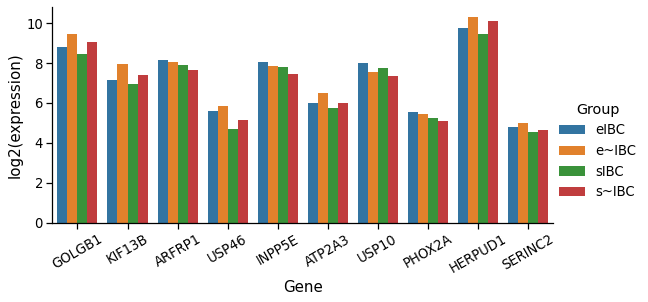

In [13]:
with sns.plotting_context('notebook', font_scale=1.2):
    g = sns.catplot(
        x='Gene', y='value', hue='Group', kind='bar',
        height=4, aspect=2,
        data=expr_avg \
            .loc[gse_data.sort_values('pval_s').index.get_level_values(0)[:5].union(
                gse_data.sort_values('pval_e').index.get_level_values(0)[:5])] \
            .melt(id_vars=['pval_s', 'pval_e'], var_name='Group', ignore_index=False) \
            .reset_index(),
            estimator=np.mean, ci=.95
    )
    g.set_xticklabels(rotation=30)
    g.set_axis_labels('Gene', 'log2(expression)', fontsize=15)

    # focus bars on region where bars are diffetent (>4)
    # add errorbars
    # also make boxplots

#### Differential Expression Volcano Plots

p-values are useful to know, but usually we also want to know the *fold change* - how different the average expression is between groups. Since the GSE data is already $log_2$ transformed, calculation of fold change should involve a subtraction, not a division!
$$
\log_2\left(\text{Fold Change}\right) = \text{mean}\left(\log_2\left(\text{Group 1}\right)\right) - \text{mean}\left(\log_2\left(\text{Group 2}\right)\right) = \log_2\left(\frac{\text{mean}\left(Group 1\right)}{\text{mean}\left(Group 2\right)}\right)
$$

In [14]:
# Add Fold Change Columns to GSE data
expr_avg['log2FC_s'] = expr_avg['sIBC'] - expr_avg['s~IBC']
expr_avg['log2FC_e'] = expr_avg['eIBC'] - expr_avg['e~IBC']
expr_avg['neglog_pval_s'] = -np.log10( expr_avg['pval_s'] )
expr_avg['neglog_pval_e'] = -np.log10( expr_avg['pval_e'] )
expr_avg['signif_s'] = (expr_avg['pval_s'] < .01).replace( {False: 'Not Significant', True: 'Significant'} )
expr_avg['signif_e'] = (expr_avg['pval_e'] < .01).replace( {False: 'Not Significant', True: 'Significant'} )

expr_avg.head(2)

,,pval_s,pval_e,eIBC,e~IBC,sIBC,s~IBC,log2FC_s,log2FC_e,neglog_pval_s,neglog_pval_e,signif_s,signif_e
ID,Gene,,,,,,,,,,,,
1007_s_at,DDR1 /// MIR4640,0.223719,0.690803,10.522208,10.576721,9.534352,9.689546,-0.155194,-0.054513,0.650297,0.160646,Not Significant,Not Significant
1053_at,RFC2,0.230290,0.923037,5.810724,5.803037,5.078497,4.960704,0.117794,0.007687,0.637725,0.034781,Not Significant,Not Significant


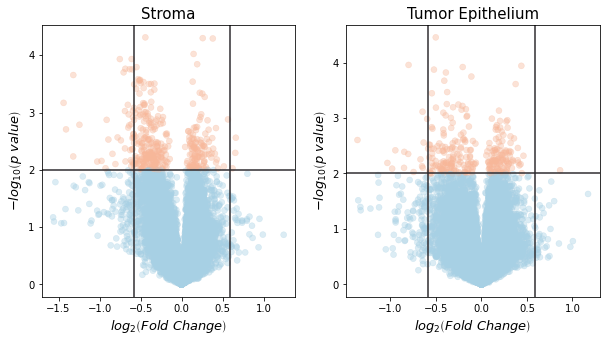

In [15]:
# Matplotlib & Seaborn Volcano Plot
name = {'_s': 'Stroma', '_e': 'Tumor Epithelium'}
with mpl.rc_context( {'figure.figsize': (10, 5)} ):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    for ax, x in zip(axes, ['_s', '_e']):
        g = sns.scatterplot(
            x='log2FC'+x, y='neglog_pval'+x, hue='signif'+x, data=expr_avg,
            hue_order=['Significant', 'Not Significant'], legend=False,
            edgecolor=None, alpha=.4, palette='RdBu', ax=ax
        )
        ax.axhline(y=2, color='#2D2A2E')
        ax.axvline(x=np.log2(2.0/3), color='#2D2A2E')
        ax.axvline(x=np.log2(3.0/2), color='#2D2A2E')
        ax.set_xlabel(r'$log_2 \left(Fold~Change\right)$', fontsize=13)
        ax.set_ylabel(r'$-log_{10} \left(p~value\right)$', fontsize=13)
        ax.set_title(name[x], fontsize=15)

### Data Analysis: Hierarchical Clustering <a class="anchor" id="da-hierarchical"></a>

Let's cluster genes and samples using hierarchical clustering.

In [16]:
# One idea is to only keep the genes that vary most across samples
# (ingoring sample groups.) This can be done using:
# Keep 90% of data
var = gse_data.iloc[:,:-2].var(axis=1)
sortedvar = np.sort( var.values )
minvar = sortedvar[ math.floor(sortedvar.size * .9) ]
gse_data_2 = gse_data.drop( gse_data[ var < minvar ].index, axis=0 )

In [17]:
# Hierarchical clustering of genes
# This would take too much time (22000 genes)

## Compute distance matrix
# dist_gene = distance.pdist(gse_data.drop(['pval_s', 'pval_e'], axis=1), metric='euclidean')
## Perform hierarchical clustering
# phy_gene = hierarchy.linkage(dist_gene, method='ward', metric='euclidean')
## Plot dendrogram

# with mpl.rc_context({'figure.figsize': (15,3)}):
#       hierarchy.dendrogram(phy_gene, orientation='top', distance_sort='descending',
#                            show_leaf_counts=True, labels=gse_data.index.get_level_values(0))

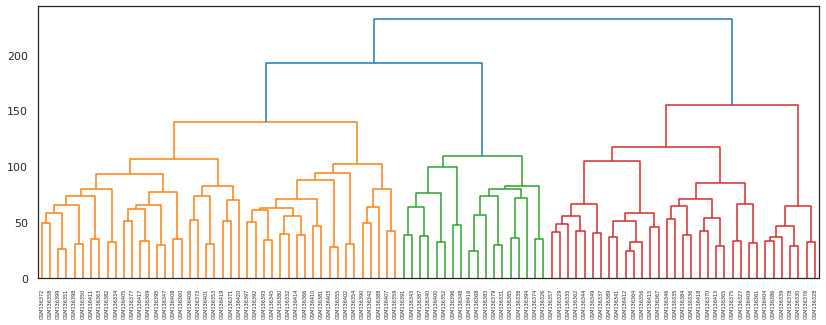

In [17]:
# Hierarchical clustering of samples
## Compute distance matrix
dist_sample = distance.pdist(gse_data_2.drop(['pval_s', 'pval_e'], axis=1).transpose(), 
                             metric='euclidean')
## Perform hierarchical clustering
phy_sample = hierarchy.linkage(dist_sample, method='ward', metric='euclidean')
## Plot dendrogram
with mpl.rc_context({'figure.figsize': (14,5)}):
    sns.set(style='white')
    hierarchy.dendrogram(phy_sample, orientation='top', distance_sort='descending',
                         show_leaf_counts=True, labels=gse_data_2.columns.get_level_values(0)[:-2])

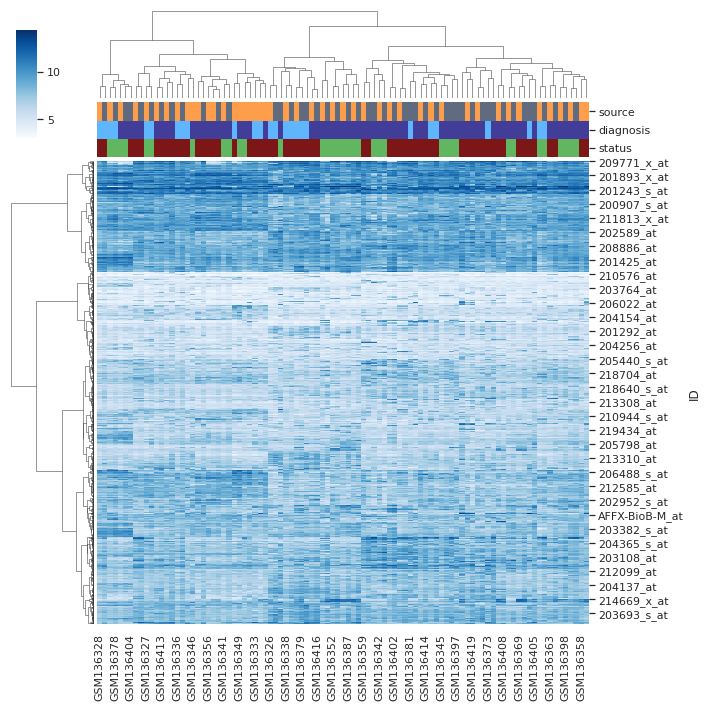

In [18]:
# Column colors
col_colors = gse.gsm_info.copy()[['source', 'diagnosis', 'status']]
col_colors['source'] = col_colors['source'].replace({'stroma': '#FF9E4A', 'epithelium': '#616b7f'})
col_colors['diagnosis'] = col_colors['diagnosis'].replace({'IBC': '#5fb6ff', 'non-IBC': '#433d9a'})
col_colors['status'] = col_colors['status'].replace({'Alive': '#60b760', 'Deceased': '#7D1717'})

# Clustergram 
sns.set(style='darkgrid')
sns.clustermap(
    gse_data_2 \
        .drop(['pval_s', 'pval_e'], axis=1) \
        .droplevel(1, axis=1).droplevel(1),
    method='ward', 
    metric='euclidean',
    cmap='Blues',
    col_colors=col_colors, 
    colors_ratio=.03, 
    dendrogram_ratio=.15, 
    cbar_pos=(0.03, 0.8, 0.03, 0.15)
);

### Data Analysis: Flat Clustering <a class="anchor" id="da-flat"></a>

You can cluster genes (or samples) without a hierarchy. There are different methods for that. You can start off from a hierarchical clustering and 'cut' the tree at a certain level to get a flat level of groupings.

In [19]:
# Create a distance matrix between pairs of genes
gene_dist = distance.pdist(gse_data_2.drop(['pval_s', 'pval_e'], axis=1), metric='correlation')
# Hierarchically cluster the genes
tree = hierarchy.linkage(gene_dist, 'average')

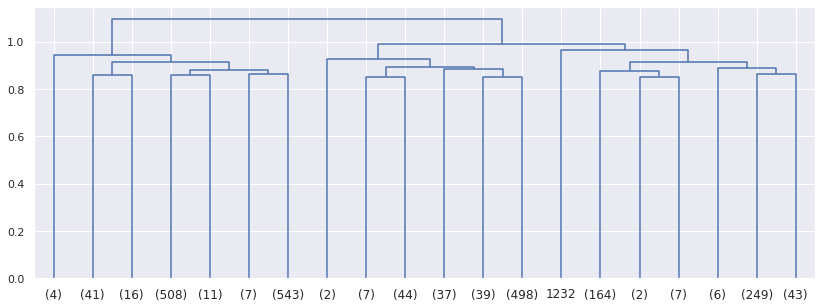

In [20]:
# Visualize the tree, show only 20 nodes
with mpl.rc_context({'figure.figsize': (14,5)}):
    hierarchy.dendrogram(tree, p=20, truncate_mode='lastp')

Next, let's cut the tree to generate 6 clusters. The result is a membership vector assigning each gene to one of the 6 clusters. We'll use the entire dataset to generate these clusters

In [21]:
# Assign each gene to a clusterr (via agglomerative clustering)
cluster = AgglomerativeClustering(n_clusters=6, linkage='ward')
iclust = cluster.fit_predict(gse_data_2.drop(['pval_s', 'pval_e'], axis=1).values) + 1

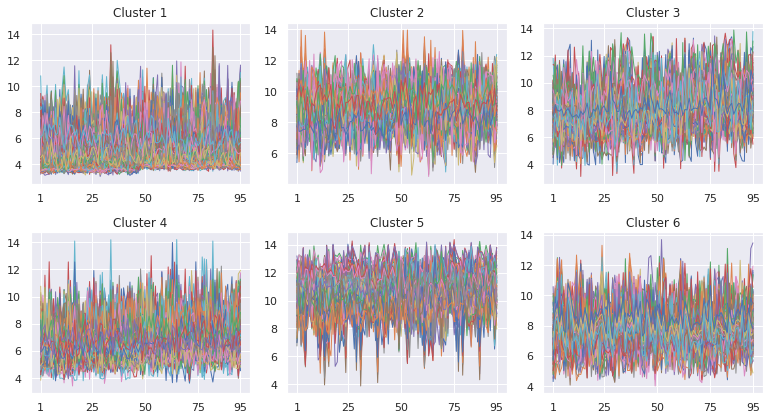

In [22]:
# Add cluster labels to gse data
gse_data_2['Cluster'] = iclust

# Plot each group of genes separately
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 6))
for i, ax in zip(range(1, 7), axes.flatten()):
    ax.plot(range(1, 96), gse_data_2.iloc[iclust == i, :-3].values.transpose(),
            linewidth=1)
    ax.set_xticks([1, 25, 50, 75, 95])
    ax.set_title(f'Cluster {i}')
fig.tight_layout()

The figures are too crowded. Let's show the average expression for the genes in each cluster.

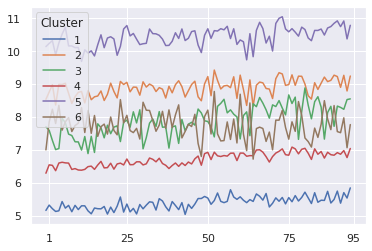

In [23]:
with mpl.rc_context({'figure.figsize': (6,4)}):
    ax = gse_data_2.drop(['pval_s', 'pval_e'], axis=1) \
        .groupby('Cluster').mean().transpose().plot.line()
    ax.set_xticks([1, 25, 50, 75, 95])
    ax.set_xticklabels([1, 25, 50, 75, 95])

If this were a time-series experiment, plotting with x axis representing time would be informative. However, in this experiment, the x axis represents samples, whose ordering doesn't mean much. Instead, let's show average values for different groups.

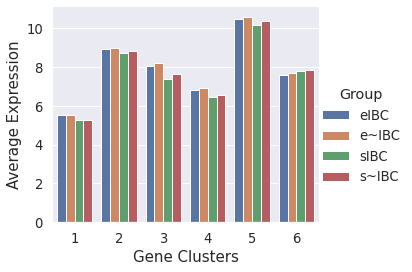

In [152]:
clust_avg = gse_data_2.drop(['pval_s', 'pval_e'], axis=1) \
    .groupby('Cluster').mean() \
    .groupby(lambda x: x[1], axis=1).mean() \
    .melt(var_name='Group', ignore_index=False) \
    .reset_index()

with sns.plotting_context('notebook', font_scale=1.2):
    sns.catplot(
        x='Cluster', y='value', hue='Group', kind='bar',
        height=4, aspect=1.2,
        data=clust_avg
    ) \
    .set_axis_labels('Gene Clusters', 'Average Expression', fontsize=15)

### Data Analysis: k-Means Clustering <a class="anchor" id="da-k-means"></a>

k-means is another method to generate groups of genes/

In [153]:
# Create Clusters
cluster = KMeans(n_clusters=6)
iclust = cluster.fit_predict(gse_data_2.iloc[:, :-2].values) + 1
gse_data_2['Cluster'] = iclust

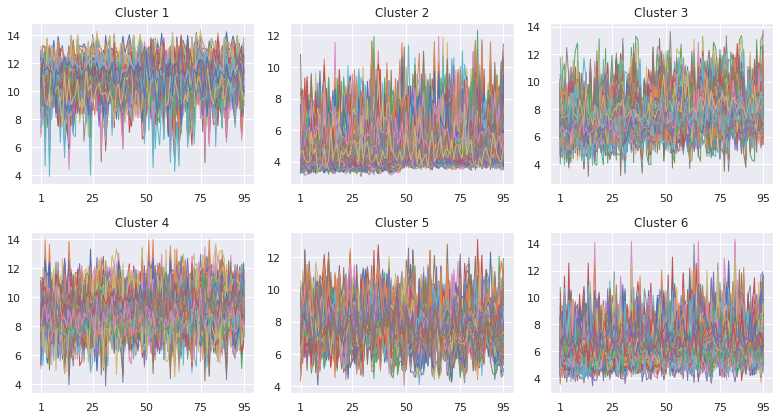

In [154]:
# Plot each group of genes separately
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11,6))
for i, ax in zip(range(1, 7), axes.flatten()):
    ax.plot(range(1, 96), gse_data_2.iloc[iclust == i, :-3].values.transpose(),
            linewidth=1)
    ax.set_xticks([1, 25, 50, 75, 95])
    ax.set_title(f'Cluster {i}')
fig.tight_layout()

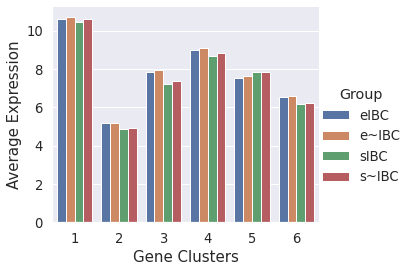

In [155]:
clust_avg = gse_data_2.drop(['pval_s', 'pval_e'], axis=1) \
    .groupby('Cluster').mean() \
    .groupby(lambda x: x[1], axis=1).mean() \
    .melt(var_name='Group', ignore_index=False) \
    .reset_index()

with sns.plotting_context('notebook', font_scale=1.2):
    sns.catplot(
        x='Cluster', y='value', hue='Group', kind='bar',
        height=4, aspect=1.2,
        data=clust_avg
    ) \
    .set_axis_labels('Gene Clusters', 'Average Expression', fontsize=15)

### Data Analysis: Principal Component Analysis (PCA) <a class="anchor" id="da-pca"></a>

Each gene is a multi-dimensional vector (as many dimensions as the number of samples). We often want to visualize genes in a lower (2D) space. Let's use PCA to reduce data dimensionality while preserving as much of the original information as possible.

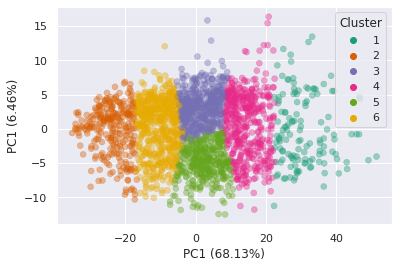

In [156]:
# PCA
pca = PCA(n_components=20)
X = pca.fit_transform(gse_data_2.iloc[:, :-3].values)
# Store reduced data in dataframe
pca_df = pd.DataFrame(X, columns=[f'PC{i}' for i in range(1,21)])
pca_df['Cluster'] = iclust

# Visualize first 2 principal components
g = sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df,
                    edgecolor=None, alpha=.4, palette='Dark2')
g.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
g.set_ylabel(f"PC1 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12);

### Data Analysis: Gene Set Enrichment <a class="anchor" id="da-gse"></a>

We have found the significantly different genes between the groups. but what do these genes do? Are there significant differences in biological functions between two groups? To answer these questions, we'll make use of the *Gene Ontology* terms, which annotate each gene to one or more Biologgical Processes, Cellular Components, and Molecular Functions.

In [24]:
# Constructe gene ontology dataframe
gplgo = gpl.table \
    .filter(regex='(^ID)|(Biological Process$)') \
    .rename(columns=lambda x: re.sub('Gene Ontology ', '', x)) \
    .dropna()

# Biological prcesses of the first microarray probe
gplgo['Biological Process'][0]

'0001558 // regulation of cell growth // inferred from electronic annotation /// 0001952 // regulation of cell-matrix adhesion // inferred from electronic annotation /// 0006468 // protein phosphorylation // inferred from electronic annotation /// 0007155 // cell adhesion // traceable author statement /// 0007169 // transmembrane receptor protein tyrosine kinase signaling pathway // inferred from electronic annotation /// 0007565 // female pregnancy // inferred from electronic annotation /// 0007566 // embryo implantation // inferred from electronic annotation /// 0007595 // lactation // inferred from electronic annotation /// 0008285 // negative regulation of cell proliferation // inferred from electronic annotation /// 0010715 // regulation of extracellular matrix disassembly // inferred from mutant phenotype /// 0014909 // smooth muscle cell migration // inferred from mutant phenotype /// 0016310 // phosphorylation // inferred from electronic annotation /// 0018108 // peptidyl-tyros

The Gene Ontology terms are given as a list separated by '///'. Let's convert each into a cell array, to make programming with them easier.

In [25]:
gplgo.iloc[:, 1] = gplgo.iloc[:, 1].apply(lambda x: x.split('///'))

In [26]:
# Let's reduce the amount of memory by keeping master lists of gene ontology information
# and have each probe have indices to that master list

# Get list of unique Gene Ontologies
GOBIO = pd.Series([x for sub in gplgo.iloc[:,1].dropna() for x in sub]).unique()
GOBIO_map = {v:i for i,v in enumerate(GOBIO)}

# Replace Gene Ontologies in dataframe
gplgo.iloc[:,1] = gplgo.iloc[:,1].dropna().apply(lambda x: [GOBIO_map[i] for i in x])

Now, each gplgo is a numeric array. To get the actual terms, use these numbers as indices to the GOBIO list

In [27]:
GOBIO[gplgo.iloc[0,1]]

array(['0001558 // regulation of cell growth // inferred from electronic annotation ',
       ' 0001952 // regulation of cell-matrix adhesion // inferred from electronic annotation ',
       ' 0006468 // protein phosphorylation // inferred from electronic annotation ',
       ' 0007155 // cell adhesion // traceable author statement ',
       ' 0007169 // transmembrane receptor protein tyrosine kinase signaling pathway // inferred from electronic annotation ',
       ' 0007565 // female pregnancy // inferred from electronic annotation ',
       ' 0007566 // embryo implantation // inferred from electronic annotation ',
       ' 0007595 // lactation // inferred from electronic annotation ',
       ' 0008285 // negative regulation of cell proliferation // inferred from electronic annotation ',
       ' 0010715 // regulation of extracellular matrix disassembly // inferred from mutant phenotype ',
       ' 0014909 // smooth muscle cell migration // inferred from mutant phenotype ',
       ' 

We have made the gplgo more convenient to work with, but we really need to get the gobio information for the gse probes. We need to take the GSE probes and search them in the GPL probes again. We can do this by merging `gplgo` with the `gse_data` data frame on the ID column.

In [28]:
gsegobio = gse_data.reset_index().iloc[:,:2]
gsegobio.columns = gse_data.reset_index().iloc[:,:2].columns.get_level_values(0)
gsegobio = gsegobio.merge(gplgo, on='ID', how='left')

Now we can go through each GOBIO term and see if our list of significant genes is enriched for that term (i.e., if that Biological Process is significantly different between the groups we are comparing). We only need to do this for the GOBIO terms that have at least one significant gene for it. If it has no significant genes for it at all, we already know that Biological Process is not affected, so no need to run a statistical test for it.

In [29]:
# Find the terms that have at least one significant gene for it.
gsegobiosig = gsegobio.iloc[((gse_data.pval_s <= .01) | (gse_data.pval_e <= .01)).values, 2]
candidategobio = pd.Series([i for sub in gsegobiosig.dropna() for i in sub]).unique()

In [30]:
# Let's just analyze the first candidate GO Biological Process
gobioid = candidategobio[0]
GOBIO[gobioid]

'0001933 // negative regulation of protein phosphorylation // inferred from genetic interaction '

### Data Analysis: Hypergeometric Test <a class="anchor" id="da-hypergeometric"></a>

To calculate the significance of a Biological Process, we'll use the hypergeometric test. We need the following four numbers:

- `x` : number of samples drawn, with the desired characteristic
- `n` : number of items with the desired characteristic in the population
- `N` : number of samples drawn
- `M` : size of the population

**Note:**  
the symbols above correspond to parameters for the `Scipy` implementation of the hypergeometric test, not the MATLAB version.  
The hypergeometric 'survival' function used below is equivalent to the upper tail of the hypergeometric distribution (`hygecdf(x,M,n,N,'upper')` in MATLAB)

In [31]:
# x: Number of significant genes that are in this term
x = (np.array([i for sub in gsegobiosig.dropna() for i in sub]) == gobioid).sum()
# K: number of genes (significant or not) that are in this term
n = (np.array([i for sub in gsegobio.iloc[:,2].dropna() for i in sub]) == gobioid).sum()
# N: total number of significant genes (ignore those with no GO term)
N = gsegobiosig.dropna().shape[0]
# M: total number of genes
M = gsegobio.shape[0]

rich.print(f"x = {x}\nn = {n}\nN = {N}\nM = {M}")

x = 1
n = 1
N = 528
M = 22283

In [32]:
# Calculate and print the pvalue for this Biological Process
pval = stats.hypergeom.sf(x, M, n, N)
print(f"pvalue = {pval:6f} for the GO Biological Process {GOBIO[gobioid]}")

pvalue = 0.000000 for the GO Biological Process 0001933 // negative regulation of protein phosphorylation // inferred from genetic interaction 


We calculated the pvalue for only one of the candidate terms. You would of course want to calculate a pvalue for all candidate terms, apply FDR correction, and report only the most significant ones.

In [108]:
# Create dataframe with GPL and GO Biological Process data
gplgo = gpl.table \
    .filter(regex='^ID|Bio') \
    .rename(columns=lambda x: re.sub('Gene Ontology ', '', x)) \
    .dropna(subset=['Biological Process'])
# Split Gene Ontologies into lists
gplgo.iloc[:, 1] = gplgo.iloc[:, 1].apply(lambda x: x.split('///'))

# Get list of unique Gene Ontologies
GOBIO = pd.Series([x for sub in gplgo.iloc[:,1] for x in sub]).unique()
GOBIO_map = {v:i for i,v in enumerate(GOBIO)}

# Replace Gene Ontologies in dataframe with numeric identifiers
gplgo.iloc[:,1] = gplgo.iloc[:,1].apply(lambda x: [GOBIO_map[i] for i in x])

# Select GOs that correspond to the GSE
gsego = gse_data.index.to_frame(index=False) \
    .merge(gplgo, on='ID', how='left')

# Find the terms that have at least one significant gene for it
gsesig_go = gsego.iloc[((gse_data['pval_s'] <= .01) | (gse_data['pval_e'] <= .01)).values, 2]
candidate_go = pd.Series([i for sub in gsesig_go.dropna() for i in sub]).unique()

In [133]:
# Perform hypergeometric tests for each of the terms in candidate_go
candidate_go

array([  496,   497,   498, ..., 24259, 24260,  1484])

In [45]:
(x, M, n, N)

(1, 22283, 1, 528)

In [52]:
def hypergeom_params(go_id, go_all, go_sig) -> tuple:
    # x: Number of significant genes that are in this term
    x = (np.array([i for sub in go_sig.dropna() for i in sub]) == go_id).sum()
    # K: number of genes (significant or not) that are in this term
    n = (np.array([i for sub in go_all.iloc[:,2].dropna() for i in sub]) == go_id).sum()
    # N: total number of significant genes (ignore those with no GO term)
    N = go_sig.dropna().shape[0]
    # M: total number of genes
    M = go_all.shape[0]

    return x, M, n, N

In [124]:
class hypergeom:
    """
    Retrieve parameters for a hypogeometric test for a specific go term
        x: Number of significant genes that are in this term
        n: number of genes (significant or not) that are in this term
        N: total number of significant genes (ignore those with no GO term)
        M: total number of genes
    """

    def __init__(self, go_all: pd.Series, go_sig: pd.Series):
        self.go_all = np.array([i for sub in go_all.dropna() for i in sub])
        self.go_sig = np.array([i for sub in go_sig.dropna() for i in sub])
        self.N = go_sig.dropna().shape[0]
        self.M = go_all.shape[0]

    def get_params(self, go_id):
        x = (self.go_sig == go_id).sum()
        n = (self.go_all == go_id).sum()

        return x, self.M, n, self.N

In [125]:
hgm = hypergeom(go_all=gsego.iloc[:,2], go_sig=gsesig_go)

In [132]:
from tqdm import tqdm
from time import sleep

In [130]:
candidate_go

array([  496,   497,   498, ..., 24259, 24260,  1484])

In [128]:
go_tests = pd.DataFrame(candidate_go)
go_tests['GO Bio Process'] = list(map({v:k for k,v in GOBIO_map.items()}.get, candidate_go))
go_tests['params'] = go_tests[0].apply(hgm.get_params)
go_tests['pvalue'] = go_tests['params'].apply(lambda x: stats.hypergeom.sf(*x))
go_tests['adj pvalue'] = fdrcorrection(go_tests['pvalue'])[1]
go_tests.drop([0, 'params'], axis=1, inplace=True)

go_tests.head()

,GO Bio Process,pvalue,adj pvalue
0,0001933 // negative regulation of protein phos...,0.000000,0.000000
1,"0001963 // synaptic transmission, dopaminergi...",0.042247,0.065080
2,0006469 // negative regulation of protein kin...,0.000000,0.000000
3,0006508 // proteolysis // inferred from elect...,0.249526,0.282747
4,0006914 // autophagy // inferred from electro...,0.049304,0.073835


In [136]:
go_tests = pd.DataFrame(candidate_go)
go_tests['GO Bio Process'] = list(map({v:k for k,v in GOBIO_map.items()}.get, candidate_go))
go_tests['params'] = go_tests[0].apply(partial(tools.hypergeom_params, go_all=gsego, go_sig=gsesig_go))
go_tests['pvalue'] = go_tests['params'].apply(lambda x: stats.hypergeom.sf(*x))
go_tests['adj pvalue'] = fdrcorrection(go_tests['pvalue'])[1]
go_tests.drop([0, 'params'], axis=1, inplace=True)

go_tests.head()

,GO Bio Process,pvalue,adj pvalue
0,0001933 // negative regulation of protein phos...,0.000000,0.000000
1,"0001963 // synaptic transmission, dopaminergi...",0.042247,0.065080
2,0006469 // negative regulation of protein kin...,0.000000,0.000000
3,0006508 // proteolysis // inferred from elect...,0.249526,0.282747
4,0006914 // autophagy // inferred from electro...,0.049304,0.073835


In [139]:
# The table below contains the significant GO Biological Processes
go_tests[go_tests['adj pvalue'] <= .01].sort_values('adj pvalue')

,GO Bio Process,pvalue,adj pvalue
0,0001933 // negative regulation of protein phos...,0.000000,0.000000
1407,0046881 // positive regulation of follicle-st...,0.000000,0.000000
1404,0045906 // negative regulation of vasoconstri...,0.000000,0.000000
1396,0035630 // bone mineralization involved in bo...,0.000000,0.000000
1388,0009892 // negative regulation of metabolic p...,0.000000,0.000000
...,...,...,...
2049,0046426 // negative regulation of JAK-STAT ca...,0.003169,0.009815
2684,0034105 // positive regulation of tissue remo...,0.003169,0.009815
2042,0030916 // otic vesicle formation // inferred...,0.003258,0.009815
2797,0014826 // vein smooth muscle contraction // ...,0.003258,0.009815
